## ECG Heartbeat Classification (MIT-BIH arrhythmia)

Note: The data [MIT-BIH arrhythmia data](https://www.physionet.org/physiobank/database/mitdb/) is taken from [kaggle](https://www.kaggle.com/shayanfazeli/heartbeat).

```
Moody GB, Mark RG. The impact of the MIT-BIH Arrhythmia Database. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209) 
```

```
Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13). 
```

A deep learning model based on temporal convolutional layers for the heartbeat classification was proposed in 

```
Kachuee, Mohammad, Shayan Fazeli, and Majid Sarrafzadeh. 
"ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).
```

Lets see how well we can do *without* introducing deep structures and learnable convolution parameters into a classifier. Without convolving the signals directly in the model, the signal preprocessing will have a significant impact on the performance of our models. 

**Spoiler**: The sparse GLM benchmark model will perform with a 85% total accuracy and a 86% total weighted recall average across the classes. We have trouble identifying only one of the five classes with a recall of 64%.

**Still to come**: Gaussian process regression and random Fourier features with a linear SVM.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We start off by loading the data and separating the target column from the training features.

In [2]:
trainpath = "../data/mitbih_train.csv"
x_train = pd.read_csv(trainpath,header=None,usecols=range(187))
y_train = pd.read_csv(trainpath,header=None,usecols=[187]).iloc[:,0]
x_train.shape

(87554, 187)

In [3]:
testpath = "../data/mitbih_test.csv"
x_test = pd.read_csv(testpath,header=None,usecols=range(187))
y_test = pd.read_csv(testpath,header=None,usecols=[187]).iloc[:,0]
x_test.shape

(21892, 187)

Lets have a look at the data. We have $\sim 80k$ samples of one-beat ECG cycles. Each sample is a $[0,1]$ interval normalized timeseries padded with zeros at the end to fit a unified timeframe.

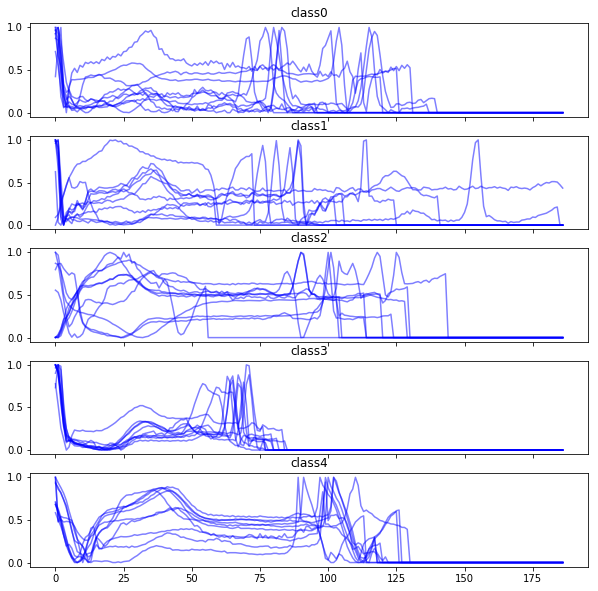

In [4]:
def plot(x_data, y_data, classes=range(5), plots_per_class=10):

    f, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(10,10))
    for i in classes:
        for j in range(plots_per_class):
            ax[i].set_title("class{}".format(i))
            ax[i].plot(x_data[y_data == i].iloc[j,:], color="blue", alpha=.5)
            
plot(x_train, y_train)

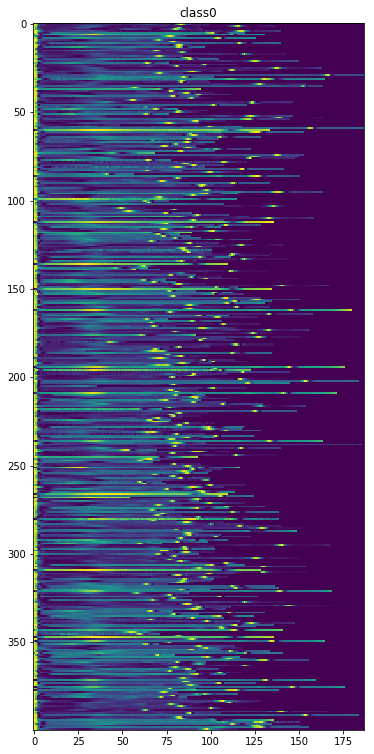

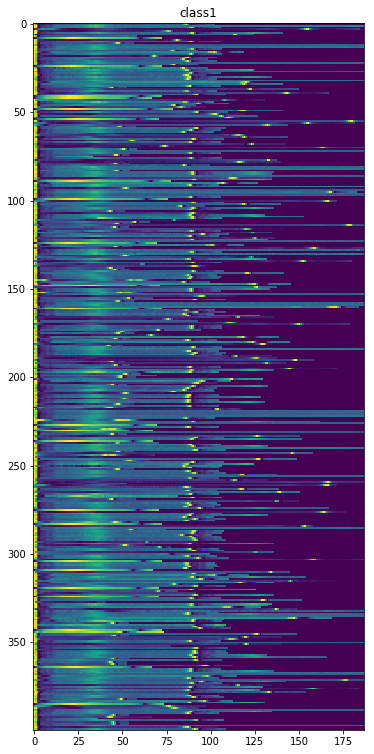

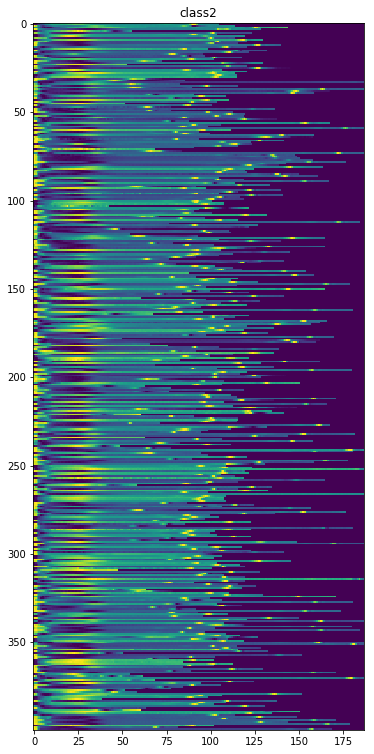

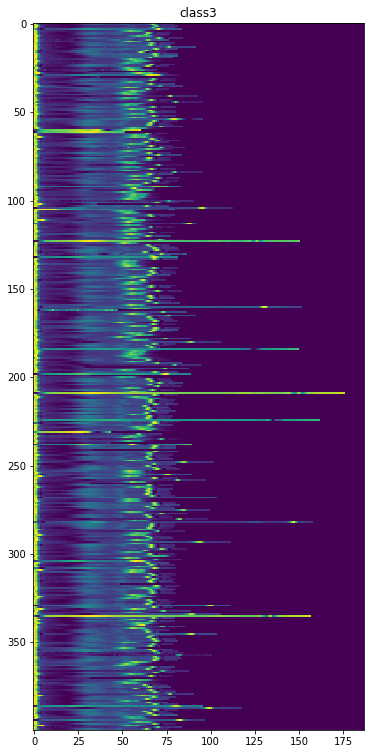

In [5]:
def class_spec(data, classnumber, n_samples):

    fig = plt.figure(figsize=(10,13))
    if type(data)==pd.DataFrame:        
        plt.imshow(data[y_train==classnumber].iloc[:n_samples,:], 
               cmap="viridis", interpolation="nearest")
    else:
        plt.imshow(data[y_train==classnumber][:n_samples,:], 
               cmap="viridis", interpolation="nearest")
    plt.title("class{}".format(classnumber))
    plt.show()
    
for i in range(4):
    class_spec(x_train, i, 400)

Lets try to understand our target variable. We have a $5$-class with a heavily oversampled "0"-class. This means, that we have to account for the underrepresented classes with a weight in the loss function later on. Else, the model might classify everything a "0" and still perform well, but this is obviously not what we want.
The class encoding has the following meaning:

| class |heart condition |
|---|---|
| 0  |  Normal, Left/Right bundle branch block, Atrial escape, Nodal escape|   
| 1  | Atrial premature, Aberrant atrial premature, Nodal premature, Supra-ventricular premature  | 
| 2  | Premature ventricular contraction, Ventricular escape  |  
| 3  | Fusion of ventricular and norma  |  
| 4  | Paced, Fusion of paced and normal, Unclassifiable  |  

The distribution of the samples across the five classes:

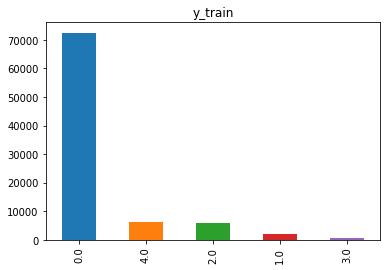

In [6]:
y_train.value_counts().plot(kind="bar", title="y_train")

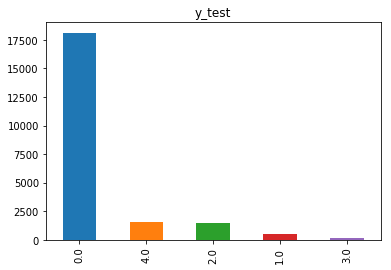

In [7]:
y_test.value_counts().plot(kind="bar", title="y_test")

### Preprocessing

Since we already have a lot of padded zeros in our data, it is only fair to make use of sparse matrices in the end by setting a threshold for our signal. Furthermore, we can add additional information by taking the magnitude of the dicrete signal gradients into account.

We can also try to add manual convolution, for example with a discrete gaussian. Similarly, we can incorporate manual max pooling by using the```pd.DataFrame.rolling``` function.

Additionally, we downsample our signal by using ```scipy.signal.decimate```-

In [8]:
from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix

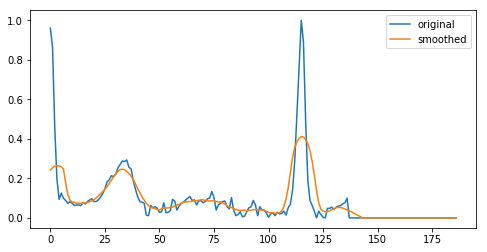

In [9]:
def gaussian_smoothing(data, window, std):
    gauss = gaussian(window ,std, sym=True)
    data = np.convolve(gauss/gauss.sum(), data, mode='same')
    return data

def gauss_wrapper(data):
    return gaussian_smoothing(data, 12, 7)

fig = plt.figure(figsize=(8,4))
plt.plot(x_train.iloc[1,:], label="original")
plt.plot(gauss_wrapper(x_train.iloc[1,:]), label="smoothed")
plt.legend()

In [10]:
def gradient(data, normalize=True):
    data = data.diff(axis=1, periods=3)
    if normalize:
        data = data.apply(lambda x: x/x.abs().max(), axis=1)
    return data

def preprocess(data): 
    data = data.abs().rolling(7, axis=1).max()
    data = data.fillna(method="bfill",axis=1)
    #data = np.apply_along_axis(gauss_wrapper, 1, data)
    data = decimate(data, axis=1, q=5)
    data[np.abs(data) < .05] = 0
    return pd.DataFrame(data)

x_train_grad = gradient(x_train)
x_test_grad = gradient(x_test)

x_train_preprocessed = preprocess(pd.concat([x_train, x_train_grad, gradient(x_train_grad)], axis=1))
x_test_preprocessed = preprocess(pd.concat([x_test, x_test_grad, gradient(x_test_grad)], axis=1))

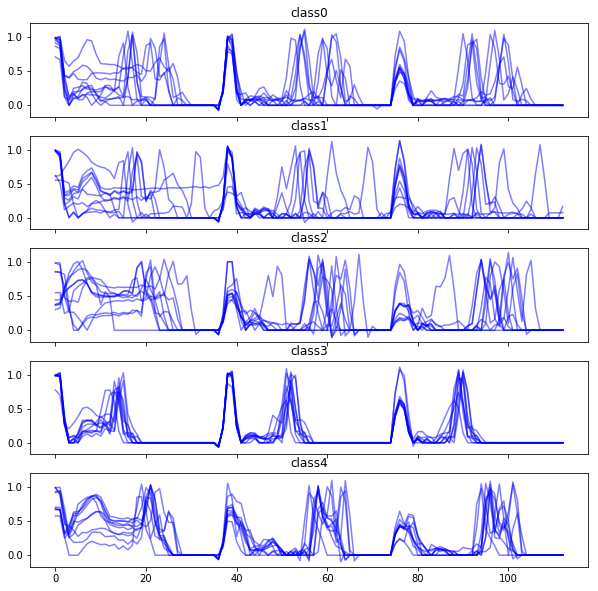

In [11]:
plot(x_train_preprocessed, y_train)

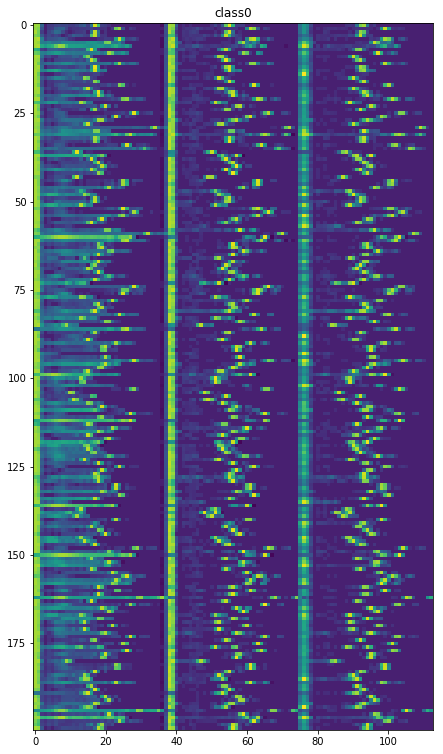

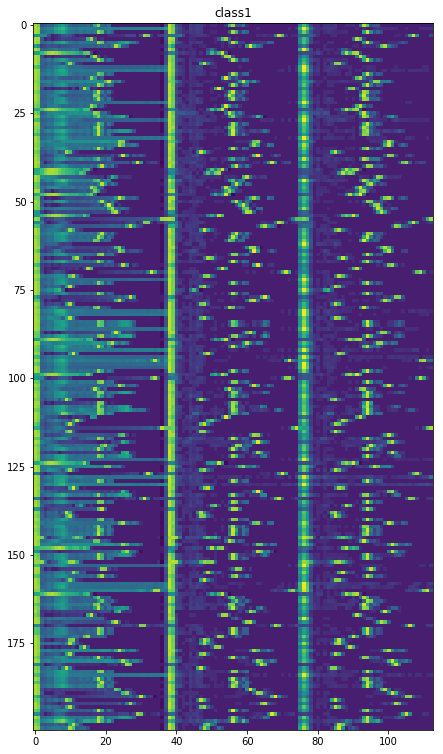

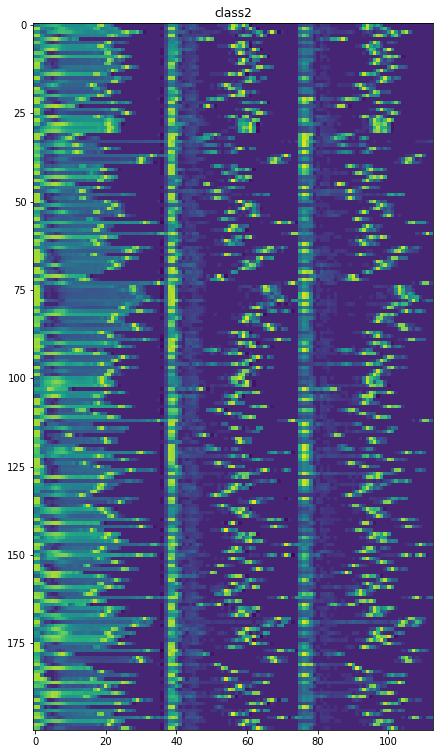

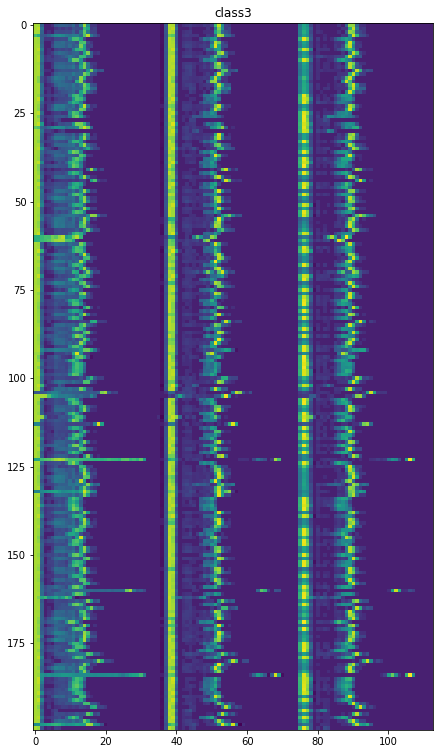

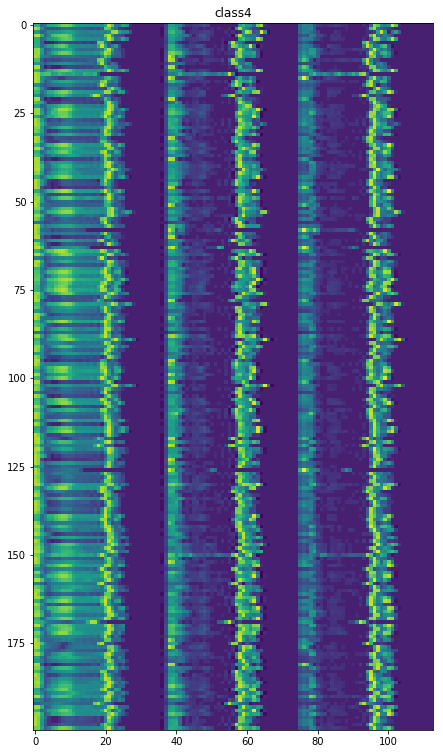

In [12]:
for i in range(5):
    class_spec(x_train_preprocessed, i, 200)

In [13]:
x_train_sparse = csr_matrix(x_train_preprocessed)

In [35]:
del x_train_grad
del x_test_grad

### Fitting a Scikit-learn benchmark sparse GLM

For a first intuition, we fit a logistic regression with a one-versus-rest approach for multilabel classification. We use the standard Newton conjugate gradient solver and add class weights according to the number of samples in the data to the loss function.

We regularize the loss with standard $L2$ penalty.

In [14]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [15]:
model = LogisticRegression(multi_class="ovr",solver="newton-cg", class_weight="balanced",
                          n_jobs=2, max_iter=150, C=.5)

start_time = time.time()
model.fit(x_train_sparse,y_train)
print("training time {}".format(time.time()-start_time))

training time 19.221577405929565


In [16]:
y_predict = model.predict(x_test_preprocessed)
cf = confusion_matrix(y_test,y_predict)
print("accuracy: " + str(accuracy_score(y_test,y_predict)))

accuracy: 0.8829709482916134


In [17]:
cf_relative = cf / cf.sum(axis=1)[:,None]

In [18]:
cf

array([[16139,   721,   479,   630,   149],
       [  161,   360,    27,     4,     4],
       [   71,    59,  1200,    84,    34],
       [   22,     1,    12,   127,     0],
       [   60,     9,    27,     8,  1504]])

In [19]:
cf_relative.round(decimals=2)

array([[0.89, 0.04, 0.03, 0.03, 0.01],
       [0.29, 0.65, 0.05, 0.01, 0.01],
       [0.05, 0.04, 0.83, 0.06, 0.02],
       [0.14, 0.01, 0.07, 0.78, 0.  ],
       [0.04, 0.01, 0.02, 0.  , 0.94]])

In [20]:
print(classification_report(y_test, y_predict))

             precision    recall  f1-score   support

        0.0       0.98      0.89      0.93     18118
        1.0       0.31      0.65      0.42       556
        2.0       0.69      0.83      0.75      1448
        3.0       0.15      0.78      0.25       162
        4.0       0.89      0.94      0.91      1608

avg / total       0.93      0.88      0.90     21892



By the nature of our problem, we are obviously interested in high recall values for each class from "1" to "4". It is significantly worse to label a person with a relevant heart condition ("1"-"4") as normal ("0") than to label a person with a normal heart ("0") as one of the latter classes ("1"-"4").

We see that our benchmark model performs quite well for the class "4", we however misclassify a significant amount of patients in the "1" and "2" class as "0".

In [21]:
del x_train
del x_test
del x_train_sparse

### Introducing nonlinearities: A random Fourier feature GLM

In [22]:
from sklearn.kernel_approximation import RBFSampler

from scipy.stats import describe
from scipy.spatial.distance import pdist

from sklearn.mixture import GaussianMixture

In [23]:
def median_heuristic(data, n_runs, n_samples):
    '''
    bootstrapping the squared euclidean distances of all data pairs to estimate the median and the mean
    
    https://arxiv.org/pdf/1707.07269.pdf
    '''
    medians = np.zeros(n_runs)
    means = np.zeros(n_runs)
    n_data = data.shape[0]
    sq_data = np.zeros((n_samples,n_samples))
    
    for i in range(n_runs):
        idx = np.random.randint(0, high = n_data, size = n_samples)
        sq_dist = np.triu(pdist(data.values[idx], metric="euclidean")**2)
        medians[i] = np.median(sq_dist)
        means[i] = np.mean(sq_dist)
        
    return medians, means

In [29]:
medians, means = median_heuristic(x_train_preprocessed, 100, 100)

In [30]:
gauss = GaussianMixture()
fit = gauss.fit(medians[:,np.newaxis])
mu = fit.means_.flatten()[0]
std = np.sqrt(fit.covariances_.flatten()[0])
print("estimated mean: {}".format(mu))
print("95% confidence: {}".format((mu-2*std/10, mu+2*std/10)))

estimated mean: 0.08759222723349333
95% confidence: (0.07737622507622226, 0.0978082293907644)


In [31]:
gauss = GaussianMixture()
fit = gauss.fit(means[:,np.newaxis])
mu = fit.means_.flatten()[0]
std = np.sqrt(fit.covariances_.flatten()[0])
print("estimated mean: {}".format(mu))
print("95% confidence: {}".format((mu-2*std/10, mu+2*std/10)))

estimated mean: 5.241464193006282
95% confidence: (5.19404104176807, 5.288887344244493)


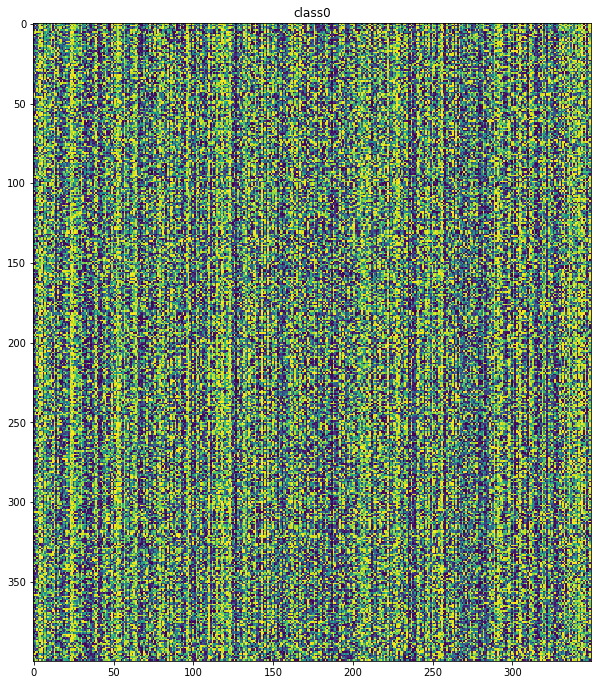

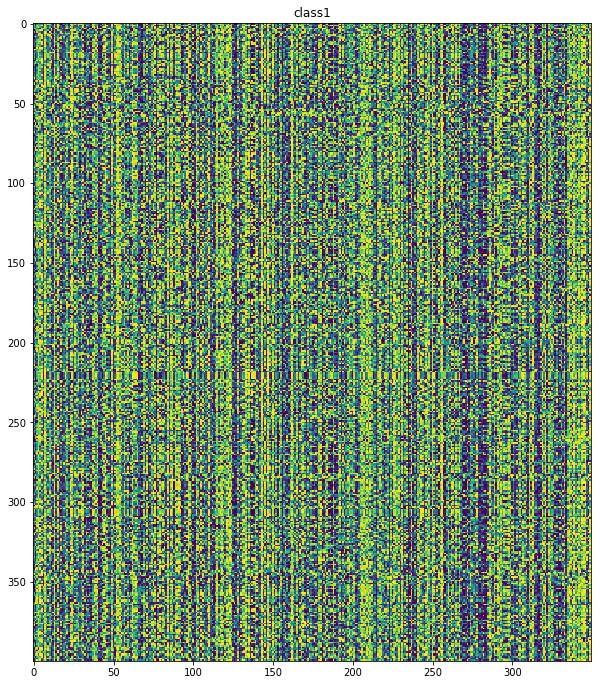

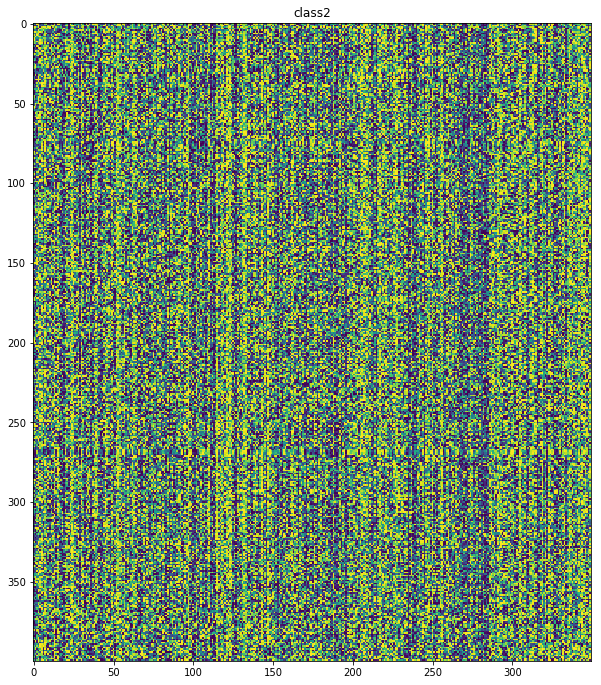

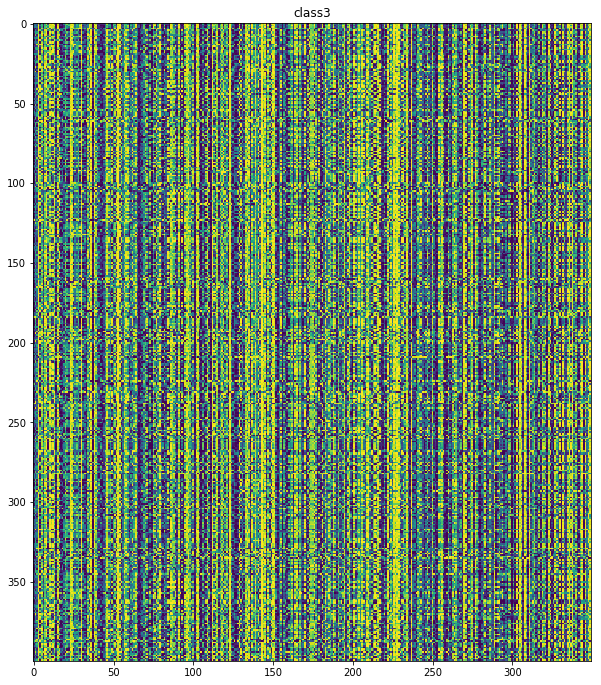

In [32]:
rbf_features = RBFSampler(gamma=.2, n_components=350)
x_rbf = rbf_features.fit_transform(x_train_preprocessed)

for i in range(4):
    class_spec(x_rbf, i, 400)

In [33]:
describe(x_rbf, axis = None)

DescribeResult(nobs=30643900, minmax=(-0.07559289460184541, 0.07559289460184504), mean=-0.0008354278209082815, variance=0.002826383820504963, skewness=0.0227822298922048, kurtosis=-1.4903296963147545)

In [37]:
model = LogisticRegression(multi_class="ovr",solver="newton-cg", class_weight="balanced",
                          n_jobs=1, max_iter=150, C=.5)

start_time = time.time()
model.fit(x_rbf,y_train)
print("training time {}".format(time.time()-start_time))

training time 38.334901332855225


In [38]:
y_predict = model.predict(rbf_features.transform(x_test_preprocessed))

In [39]:
print("accuracy: " + str(accuracy_score(y_test,y_predict)))

accuracy: 0.9017906084414398


In [40]:
confusion_matrix(y_test, y_predict)

array([[16484,   627,   533,   395,    79],
       [  123,   395,    31,     4,     3],
       [   66,    38,  1233,    76,    35],
       [   12,     4,     6,   140,     0],
       [   56,     9,    42,    11,  1490]])

In [41]:
cf_relative = cf / cf.sum(axis=1)[:,None]
print(cf_relative.round(decimals=2))

[[0.89 0.04 0.03 0.03 0.01]
 [0.29 0.65 0.05 0.01 0.01]
 [0.05 0.04 0.83 0.06 0.02]
 [0.14 0.01 0.07 0.78 0.  ]
 [0.04 0.01 0.02 0.   0.94]]


In [42]:
print(classification_report(y_test, y_predict))

             precision    recall  f1-score   support

        0.0       0.98      0.91      0.95     18118
        1.0       0.37      0.71      0.48       556
        2.0       0.67      0.85      0.75      1448
        3.0       0.22      0.86      0.36       162
        4.0       0.93      0.93      0.93      1608

avg / total       0.94      0.90      0.92     21892

